In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from torchvision import datasets
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Load Data
We load MNIST data from the torchvision datasets.

Since We would be using built-in pytorch methods in this notebook, it is very straightforward to perform preprocessing steps such as z-score normalization using a series of transformations as torchvision.transforms.Compose:
#### - ToTensor(): Converts the images to PyTorch tensors.
#### - Normalize(): Z-score normalization of pixel values using predefined mean and standard deviation.

### Dataset and Dataloaders
#PyTorch provides the concept of datasets and dataloaders to efficiently handle and process large datasets during training.

### Dataset
A dataset in PyTorch represents a collection of data samples and their corresponding labels. For our task, we have loaded the MNIST dataset using torchvision.datasets.MNIST. If we need a custom dataset, we can create a new class that inherits from Pytorch's Dataset class and define some essential function as explained here https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files 

### Dataloader
A dataloader is an iterator that provides efficient and parallel access to the dataset. It automatically handles batching, shuffling, and data loading in parallel.

In [2]:
# loading training data
transforms_MNIST = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean = (0.1307,), std = (0.3081,))
    ]
)
train_dataset = datasets.MNIST(root='./data', 
                               train=True, 
                               transform=transforms_MNIST,
                               download=True)
#loading test data
test_dataset = datasets.MNIST(root='./data', 
                              train=False, 
                              transform=transforms_MNIST)

### Example Images

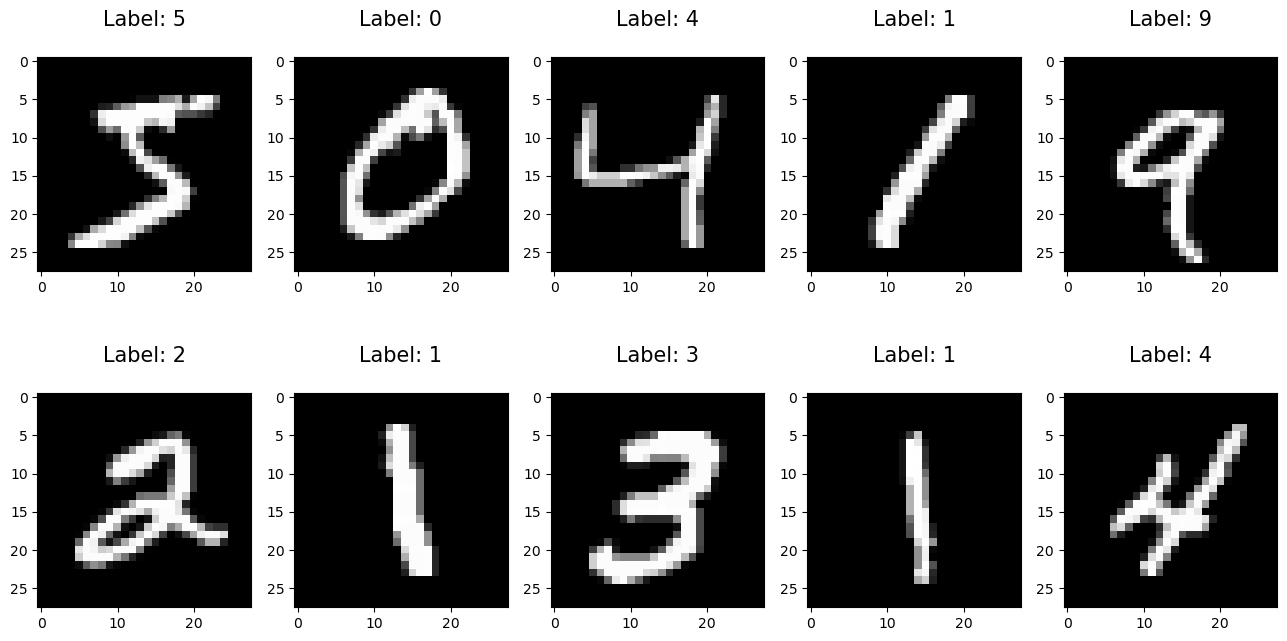

In [3]:
plt.figure(figsize=(16,8))
for index in range(10):
    plt.subplot(2, 5, index + 1)
    image = train_dataset[index][0]
    label = train_dataset[index][1]
    plt.imshow(np.reshape(image.numpy(), (28,28)), cmap=plt.cm.gray)
    plt.title('Label: %i\n' % label, fontsize = 15);

# Data Processing
As before, we perform the following data processing steps

#### Label Conversion
#### Z Score Normalization
We have already applied z-score normalization using torchvision.transforms.Normalize during dataset loading.
#### Adding bias feature
Adding a bias feature to the input data is a common practice in logistic regression. However, PyTorch's linear layer (torch.nn.Linear) automatically adds a bias term by default. Hence, we don't need to explicitly add a bias feature.
#### Train - Val Split

We have already performed z-score-normalization using torchvision transforms. More details for the rest follow below

### Label Conversion
Like before, we'll map label 0 to class 0 and label 3 to class 1. 
You can choose to work with different pairs and compare the results

In [4]:
label1 = 0
label2 = 3

In [5]:
# We create these subsets for binary classification (train_minset and test_minset) using torch.utils.data.Subset.
train_indices = [idx for idx, target in enumerate(train_dataset.targets) if target in [label1, label2]]
test_indices = [idx for idx, target in enumerate(test_dataset.targets) if target in [label1, label2]]

train_minset = torch.utils.data.Subset(train_dataset, train_indices)
test_minset = torch.utils.data.Subset(test_dataset, test_indices)

binary_label_mapping = {label1: 0, label2: 1}
# Update the train_minset targets
for idx in range(len(train_minset)):
    old_target = train_minset.dataset.targets[train_minset.indices[idx]]
    new_target = binary_label_mapping[old_target.item()]
    train_minset.dataset.targets[train_minset.indices[idx]] = new_target

# Update the test_minset targets
for idx in range(len(test_minset)):
    old_target = test_minset.dataset.targets[test_minset.indices[idx]]
    new_target = binary_label_mapping[old_target.item()]
    test_minset.dataset.targets[test_minset.indices[idx]] = new_target

### Train-Val Split
We have split the training data into train_minset and val_minset using the torch.utils.data.random_split function.
This function takes care of creating random subsets of the data for training and validation as follows

In [6]:
num_validation_samples = 2060

train_minset, val_minset = torch.utils.data.random_split (train_minset, 
                                                          [len(train_minset)-num_validation_samples, num_validation_samples], generator=torch.Generator().manual_seed(1))


print("number of training samples: " + str(len(train_minset)) + "\n" +
      "number of vlidation samples: " + str(len(val_minset)) + "\n" +
      "number of testing samples: " + str(len(test_minset)))

number of training samples: 9994
number of vlidation samples: 2060
number of testing samples: 1990


### Dataloader Creation
We then create dataloaders for the train, validation, and test datasets using torch.utils.data.DataLoader.
These dataloaders efficiently handle batching, shuffling, and loading of the data during training and evaluation.
The train_loader shuffles the data to introduce randomness during training.

In [7]:
# load train and test data samples into dataloader
batch_size = 128
train_loader = DataLoader(dataset=train_minset, batch_size=batch_size, shuffle=True) 
val_loader = DataLoader(dataset=val_minset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_minset, batch_size=batch_size, shuffle=False)

# Logistic Regression Model

### Model Definition
Here we define our logistic regression model using PyTorch's neural network module, torch.nn.Module. We can define custom model for any task by inheriting pytorch's torch.nn.Module class and instantiating all the layers in the __init__ method and defining a forward pass in the forward method. Based on this information alone torch.nn.Module can perform backward step and all other computations.

A logistic regression model can be thought of as a neural network consistsing of a single linear layer followed by a sigmoid activation function. The model takes input features, performs a linear transformation, and maps the output to a probability score between 0 and 1.

To create our custom logistic regression model, we'll follow these steps:

1. **Import PyTorch and Define the Model Class**: We start by importing the necessary libraries and then define our custom model class, `LogisticRegression`, which inherits from `torch.nn.Module`.

2. **Initialize the Model Layers**: In the `__init__` method of our model class, we instantiate the linear layer using `torch.nn.Linear`. The linear layer takes two arguments: `input_size` (the number of input features) and `output_size` (the desired output size).

3. **Define the Forward Pass**: The `forward` method is where we define the forward pass of our model. It takes an input tensor `x` and applies the linear transformation defined in the `__init__` method and a sigmoid activation. The result is returned as the output of the model.


For more complex tasks, you can extend this approach by adding additional layers, activation functions, and custom operations within the forward method.

To see further examples and detailed tutorials on creating custom models in PyTorch, you can refer to the official PyTorch documentation and tutorials, such as the one provided here: https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html






In [8]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_size, output_size)
    def forward(self, x):
        return (self.linear(x))

# Loss function
Same as the custom Model, we can also define a custom loss function by inheriting from `torch.nn.Module` class and implementing the `forward` method to calculate the loss. 

In the case of binary classification, you might want to implement a custom binary cross-entropy loss or use one of PyTorch's pre-defined loss functions. For binary classification, the torch.nn.BCEWithLogitsLoss is commonly used, which combines sigmoid activation and binary cross-entropy loss in a numerically stable way. torch.nn.BCELoss only computed binary cross-entropy loss on labels.

In [9]:
class CustomBCEWithLogitsLoss(torch.nn.Module):
    def __init__(self):
        super(CustomBCEWithLogitsLoss, self).__init__()

    def forward(self, predictions, targets):
        # Apply sigmoid activation
        sigmoid_predictions = torch.sigmoid(predictions)

        # Calculate binary cross-entropy loss
        loss = -(targets * torch.log(sigmoid_predictions + 1e-7) + (1 - targets) * torch.log(1 - sigmoid_predictions + 1e-7))
        mean_loss = torch.mean(loss)
        return mean_loss

### Instantiate the Custom Model
Next we need to instantiate our custom logistic regression model by providing the input size (number of features) and output size (number of classes).
We also define the loss function (criterion) and optimizer.


In [10]:
# instantiate the model
n_inputs = 28*28 # makes a 1D vector of 784
n_outputs = 1

model = LogisticRegression(n_inputs, n_outputs)

# Loss function and optimizer
criterion = CustomBCEWithLogitsLoss()  # Binary Cross-Entropy loss
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.99)  # Stochastic Gradient Descent optimizer

# Training and Evaluation

After defining a pytorch module, we still need to train it as before. However, pytorch does some of the heavy lifting for us (for example - generating minibatches, computing and updating gradients, computing loss etc.) 

We again keep track of various metrics during training, including the training loss, validation loss, and validation accuracy. These metrics provide insights into how well the model is learning and generalizing to unseen data.
To prevent overfitting and improve training efficiency, the code also implements early stopping. If the validation loss starts increasing after a certain number of epochs, the training process is halted early.

In [11]:
epochs = 500
train_loss = []
vali_loss = []
vali_acc = []

best_val_loss = float('inf')  # Initialize with a large value for early stopping
patience = 10  # Number of epochs to wait for improvement before early stopping

for epoch in range(epochs):
    correct = 0
    total_loss = 0
    batch = 0

    # Training loop
    model.train()  # Set the model to training mode
    for i, (images, labels) in enumerate(train_loader):
        labels = labels.float()
        optimizer.zero_grad()
        outputs = model(images.view(-1, 28*28))
        
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        batch += 1

    train_loss.append(total_loss / batch)

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        correct = 0
        total_val_loss = 0
        batch = 0
        total_pred = 0
        
        for images, labels in val_loader:
            labels = labels.float()
            outputs = model(images.view(-1, 28*28))
            
            val_loss = criterion(outputs, labels.unsqueeze(1))
            total_val_loss += val_loss.item()
            batch += 1

            predicted = (outputs >= 0.5).float()  # Convert to binary predictions
            correct += (predicted == labels.unsqueeze(1)).sum().item()
            total_pred += predicted.shape[0]


    vali_loss.append(total_val_loss / batch)
    val_accuracy = 100 * correct / total_pred
    vali_acc.append(val_accuracy)

    if epoch % 50 == 0:
        print('Epoch: {}. Train Loss: {:.4f}. Val Loss: {:.4f}. Val Accu: {:.4f} %'.format(epoch, train_loss[epoch], vali_loss[epoch], vali_acc[epoch]))

    # Early stopping check
    if vali_loss[-1] < best_val_loss:
        best_val_loss = vali_loss[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print('Early stopping at epoch', epoch)
            break


Epoch: 0. Train Loss: 0.3086. Val Loss: 0.1003. Val Accu: 96.8447 %
Epoch: 50. Train Loss: 0.0149. Val Loss: 0.0272. Val Accu: 99.1748 %
Epoch: 100. Train Loss: 0.0122. Val Loss: 0.0262. Val Accu: 99.2233 %
Early stopping at epoch 105


# Training and Validation Plots

The following plot provides valuable insights into the training process and helps identify any anomalies:

This visualization allows us to:
- Monitor the **training and validation loss** to gauge the model's convergence and potential overfitting.
- Track the **validation accuracy** to assess how well the model generalizes.

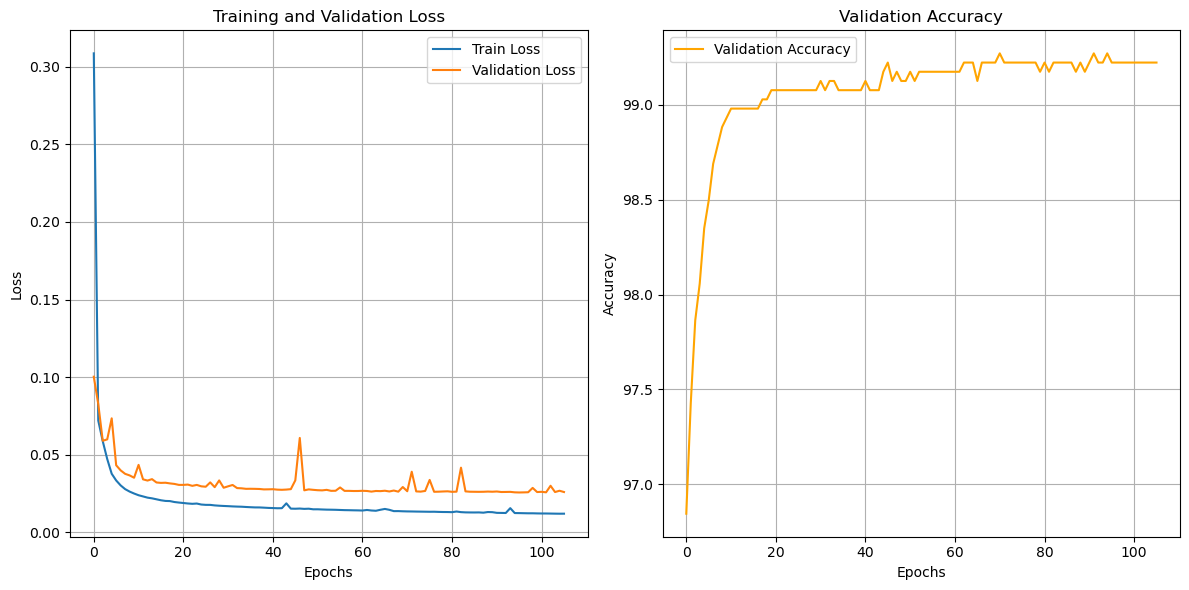

In [12]:
plt.figure(figsize=(12, 6))

# Plotting Training Loss and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(vali_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plotting Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(vali_acc, label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Weights Visualization

The code below visualizes the weights of the the logistic regression model. The initial set of weights corresponds to the bias, which is often not of primary interest. Therefore, we focus on visualizing the weights associated with the actual features.

By reshaping and plotting the weights as an image, we gain insights into how the model learns and assigns importance to different features. This can help us interpret the learned patterns and identify which areas of the input data contribute most to the model's decisions.

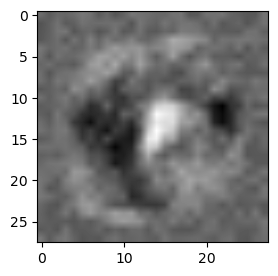

In [13]:
# Weights Visualization
layer_weights = model.linear.weight
layer_biases = model.linear.bias

plt.figure(figsize=(3,3))
plt.imshow(layer_weights.cpu().detach().numpy().reshape(28,28), cmap = 'gray', interpolation = 'bilinear')

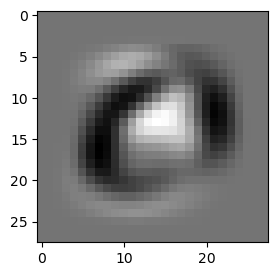

In [14]:
label1data = []
label2data = []
for data, label in train_minset:
    if label == 0: 
        label1data.append(data.cpu().detach().numpy().reshape(-1,784))
    elif label == 1:
        label2data.append(data.cpu().detach().numpy().reshape(-1,784))
        
label1data = np.array(label1data)        
label2data = np.array(label2data)


avg_label2 = np.sum(label2data, axis = 0)/label2data.shape[0]
avg_label1 = np.sum(label1data, axis = 0)/label1data.shape[0]

diff_img = avg_label2 - avg_label1

plt.figure(figsize=(3,3))
plt.imshow(diff_img.reshape(28,28), cmap = 'gray')

### Test Performance
Now that we have trained our model , we can use our test set to test its performance



In [15]:
# Test loop
model.eval()
test_loss = 0
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        labels = labels.float()
        outputs = model(images.view(-1, 28 * 28))
        test_loss += criterion(outputs, labels.unsqueeze(1)).item()

        predicted = (torch.sigmoid(outputs) >= 0.5).float()
        test_correct += (predicted == labels.unsqueeze(1)).sum().item()
        test_total += len(labels)

test_accuracy = 100 * test_correct / test_total
test_avg_loss = test_loss / len(test_loader)
print(f'Test Accuracy: {test_accuracy:.2f}%')
print(f'Test Average Loss: {test_avg_loss:.4f}')

Test Accuracy: 99.75%
Test Average Loss: 0.0099


# Softmax Regression Model

We set up a similar pytorch model for softmax regression. As you would remember from the previous notebook, we did 3 things differently for softmax regression.
1. One hot encoding
2. Softmax Activation
3. Multi-class Cross Entropy Loss

We will use pytorch methods for all of these steps this time

# Data Processing
As before, we perform the following data processing steps, with the addition of one hot encoding and skipping label conversion

#### One hot encoding
Although there are pytorch functions to one-hot encode our labels, we don't need to explicitly encode our labels since we will be using pytorch's Cross Entropy loss which  will take care of one hot encoding/decoding.
#### Z Score Normalization
We have already applied z-score normalization using torchvision.transforms.Normalize during dataset loading.
#### Adding bias feature
Adding a bias feature to the input data is a common practice in logistic regression. However, PyTorch's linear layer (torch.nn.Linear) automatically adds a bias term by default. Hence, we don't need to explicitly add a bias feature.
#### Train - Val Split


In [16]:
# Apply one-hot encoding to the targets - Only needed if you are writing your custom loss function
# train_dataset.targets = torch.nn.functional.one_hot(train_dataset.targets, num_classes=10)
# test_dataset.targets = torch.nn.functional.one_hot(test_dataset.targets, num_classes=10)

# Train-val Split
num_validation_samples = 2060
    
train_dataset, val_dataset = torch.utils.data.random_split (train_dataset, 
                                                          [len(train_dataset)-num_validation_samples, num_validation_samples], generator=torch.Generator().manual_seed(1))

print("number of training samples: " + str(len(train_dataset)) + "\n" +
      "number of vlidation samples: " + str(len(val_dataset)) + "\n" +
      "number of testing samples: " + str(len(test_dataset)))

number of training samples: 57940
number of vlidation samples: 2060
number of testing samples: 10000


### Dataloader Creation


In [17]:
# load train and test data samples into dataloader
batch_size = 128
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True) 
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Softmax Regression Model

### Model Definition
We define our softmax regression model using PyTorch's neural network module again.
A softmax regression model can be thought of as a neural network consistsing of a single linear layer followed by a softmax activation function. The model takes input features, performs a linear transformation, and maps the output to 'n' output nodes, where 'n' is the number of classes in the dataset. Since we are using sigmoid activation, these 10 output node values will be a probability score between 0 and 1.


### Note that we are essentially using the same pytorch module for softmax

Since we are implementing the sigmoid/softmax activation in the loss function instead, we could get away with using the same module for Logistic and Softmax regression, initialized with the correct number of output size (1 and 10 respectively).

But let's still define a new module, just for a better separation 

In [18]:
class SoftmaxRegression(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(SoftmaxRegression, self).__init__()
        self.linear = torch.nn.Linear(input_size, output_size)
    def forward(self, x):
        return (self.linear(x))

# Loss function

In the case of multiclass classification, you might want to implement a multiclass cross-entropy loss or use one of PyTorch's pre-defined loss functions. For multiclass classification, the torch.nn.CrossEntropyLoss is commonly used, which combines softmax activation and cross-entropy loss in a numerically stable way.
Let's use the pre-defined function this time.

### Instantiate the Custom Model

Next we need to instantiate our custom logistic regression model by providing the input size (number of features) and output size (number of classes).
We also instantiate the loss function (criterion) and optimizer.

In [32]:
# instantiate the model
n_inputs = 28*28 # makes a 1D vector of 784
n_outputs = 10

model = SoftmaxRegression(n_inputs, n_outputs)

# Loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()  # Cross-Entropy loss
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.99)  # Stochastic Gradient Descent optimizer

# Training and Evaluation

Exactly as before, minor changes to account for the behaviour of Cross Entropy loss and to calculate softmax accuracy

In [33]:
epochs = 100
train_loss = []
vali_loss = []
vali_acc = []

best_val_loss = float('inf')  # Initialize with a large value for early stopping
patience = 10  # Number of epochs to wait for improvement before early stopping

for epoch in range(epochs):
    correct = 0
    total_loss = 0
    batch = 0

    # Training loop
    model.train()  # Set the model to training mode
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(images.view(-1, 28*28))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        batch += 1

    train_loss.append(total_loss / batch)

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        correct = 0
        total_val_loss = 0
        batch = 0
        total_pred = 0
        
        for images, labels in val_loader:
            outputs = model(images.view(-1, 28*28))
            
            val_loss = criterion(outputs, labels)
            total_val_loss += val_loss.item()
            batch += 1

            predicted = torch.argmax(outputs, dim=1)  # Get the class with the highest probability
            correct += (predicted == labels).sum().item()
            total_pred += predicted.shape[0]


    vali_loss.append(total_val_loss / batch)
    val_accuracy = 100 * correct / total_pred
    vali_acc.append(val_accuracy)

    if epoch % 10 == 0:
        print('Epoch: {}. Train Loss: {:.4f}. Val Loss: {:.4f}. Val Accu: {:.4f} %'.format(epoch, train_loss[epoch], vali_loss[epoch], vali_acc[epoch]))

    # Early stopping check
    if vali_loss[-1] < best_val_loss:
        best_val_loss = vali_loss[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print('Early stopping at epoch', epoch)
            break


Epoch: 0. Train Loss: 0.7047. Val Loss: 0.3905. Val Accu: 88.6893 %
Epoch: 10. Train Loss: 0.2936. Val Loss: 0.2841. Val Accu: 91.9417 %
Epoch: 20. Train Loss: 0.2797. Val Loss: 0.2692. Val Accu: 92.5243 %
Epoch: 30. Train Loss: 0.2724. Val Loss: 0.2736. Val Accu: 92.5728 %
Epoch: 40. Train Loss: 0.2678. Val Loss: 0.2575. Val Accu: 92.7184 %
Epoch: 50. Train Loss: 0.2641. Val Loss: 0.2637. Val Accu: 92.5243 %
Early stopping at epoch 58


# Training and Validation Plots

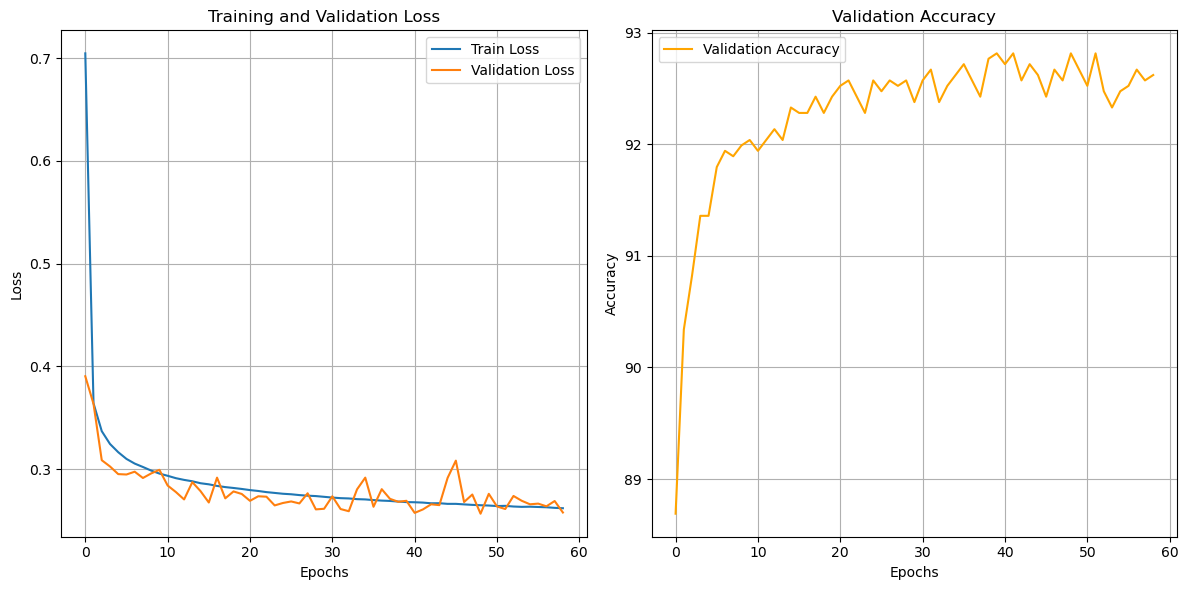

In [34]:
plt.figure(figsize=(12, 6))

# Plotting Training Loss and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(vali_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plotting Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(vali_acc, label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Weights Visualization


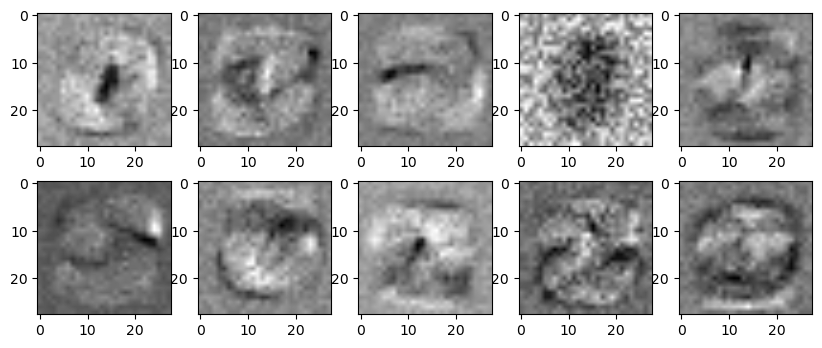

In [40]:
# Weights Visualization
layer_weights = model.linear.weight
layer_biases = model.linear.bias

# plt.figure(figsize=(3,3))
# plt.imshow(layer_weights.cpu().detach().numpy().reshape(28,28), cmap = 'gray', interpolation = 'bilinear')

fig, axarr = plt.subplots(2, 5, figsize=(10,4))
for i in range(0,10):
    a = int(i/5)
    b = int(i%5)
    axarr[a,b].imshow(layer_weights[i].cpu().detach().numpy().reshape(28,28), cmap = 'gray', interpolation = 'bilinear')


### Test Performance
Now that we have trained our model , we can use our test set to test its performance



In [44]:
# Test loop
model.eval()
test_loss = 0
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images.view(-1, 28 * 28))
        test_loss += criterion(outputs, labels).item()

        predicted = torch.argmax(outputs, dim=1)  # Get the class with the highest probability
        test_correct += (predicted == labels).sum().item()
        test_total += len(labels)

test_accuracy = 100 * test_correct / test_total
test_avg_loss = test_loss / len(test_loader)
print(f'Test Accuracy: {test_accuracy:.2f}%')
print(f'Test Average Loss: {test_avg_loss:.4f}')

Test Accuracy: 92.03%
Test Average Loss: 0.2762
